**Note:**  
  
1 This file is exactly the sec_notebook.ipynb from Dr. Sina Khosravi, but I added comments to improve clarity.

2 The dataset that got used in ChemBERTa_Repurposing.ipynb and Initial_Repurposing.ipynb was created here. (main_dataset for train.csv)

In [ ]:
!git clone https://github.com/khosravisina/anti_CETP.git



Cloning into 'anti_CETP'...
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 9 (delta 1), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (9/9), 733.25 KiB | 2.19 MiB/s, done.
Resolving deltas: 100% (1/1), done.


In [ ]:
! pip install pandas
! pip install numpy
! pip install seaborn
! pip install matplotlib
! pip install rdkit
! pip install datamol
! pip install sklearn

In [ ]:
! pip install scikit-fingerprints
! pip install shap

In [ ]:
! pip install xgboost

In [ ]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import Descriptors, rdMolDescriptors
from IPython.display import display
import datamol as dm
from skfp.fingerprints import MordredFingerprint, PubChemFingerprint, RDKitFingerprint, ECFPFingerprint, MACCSFingerprint, RDKit2DDescriptorsFingerprint, MAPFingerprint

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import ParameterGrid
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import Lasso, LassoCV, ElasticNet, ElasticNetCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, matthews_corrcoef, f1_score, confusion_matrix, accuracy_score, recall_score, precision_score, balanced_accuracy_score
from sklearn.model_selection import cross_validate , RepeatedStratifiedKFold, train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, VotingClassifier

import xgboost as xgb
from xgboost import XGBClassifier

import shap

In [ ]:
def calculate_fingerprint(mols):
    fingerprint_dic = {
        'PubChem': PubChemFingerprint(), 'ECFP': ECFPFingerprint(radius=2),
        'rdkit-dec':RDKit2DDescriptorsFingerprint(),
        'Map4': MAPFingerprint(fp_size=2048),
    }

    all_data = {}
    for finger in fingerprint_dic:
        func = fingerprint_dic[finger]
        finger_desc = func.transform(mols)
        feature_name = func.get_feature_names_out()
        finger_df = pd.DataFrame(finger_desc, columns=feature_name)
        all_data[f'{finger}'] = finger_df

    return all_data




In [ ]:
df_main = pd.read_csv("/content/anti_CETP/main_dataset for train.csv")

In [ ]:
df_main.head()

,Name,Smiles,pIC50,activity
0,CHEMBL125473,OC(CN(Cc1cccc(C(F)(F)F)c1)c1cccc(F)c1)C(F)(F)F,4.431798,inactive
1,CHEMBL128218,Cc1ccccc1CN(CC(O)C(F)(F)F)c1cccc(F)c1,4.000000,inactive
2,CHEMBL127895,OC(CN(Cc1cccc(OC(F)(F)F)c1)c1cccc(Oc2ccccc2)c1...,4.397940,inactive
3,CHEMBL337966,CC(C)Cc1cccc(CN(CC(O)C(F)(F)F)c2cccc(Oc3ccccc3...,6.267606,inactive
4,CHEMBL340310,O[C@@H](CN(Cc1cccc(OC(F)(F)C(F)F)c1)c1cccc(Oc2...,6.096910,inactive


In [ ]:
# stratified random split
train_df, test_df = train_test_split(
    df_main,
    test_size=0.2,
    stratify=df_main['activity'],
    random_state=42
)


train_df = train_df.copy()
train_df['dataset'] = 'train'
test_df = test_df.copy()
test_df['dataset'] = 'test'

final_df = pd.concat([train_df, test_df]).reset_index(drop=True)


## dataset for split
To repurpose drugs for other problems.

In [ ]:
# Displaying ChEMBL Drugs Data
df = dm.data.chembl_drugs(as_df=True) #as_df=True: This argument tells the function to return the retrieved data as a Pandas DataFrame.

df.head()


,first_approval,molecule_chembl_id,molecule_type,pref_name,smiles
0,1976.0,CHEMBL2,Small molecule,PRAZOSIN,COc1cc2nc(N3CCN(C(=O)c4ccco4)CC3)nc(N)c2cc1OC
1,1984.0,CHEMBL3,Small molecule,NICOTINE,CN1CCC[C@H]1c1cccnc1
2,1990.0,CHEMBL4,Small molecule,OFLOXACIN,CC1COc2c(N3CCN(C)CC3)c(F)cc3c(=O)c(C(=O)O)cn1c23
3,1964.0,CHEMBL5,Small molecule,NALIDIXIC ACID,CCn1cc(C(=O)O)c(=O)c2ccc(C)nc21
4,1965.0,CHEMBL6,Small molecule,INDOMETHACIN,COc1ccc2c(c1)c(CC(=O)O)c(C)n2C(=O)c1ccc(Cl)cc1


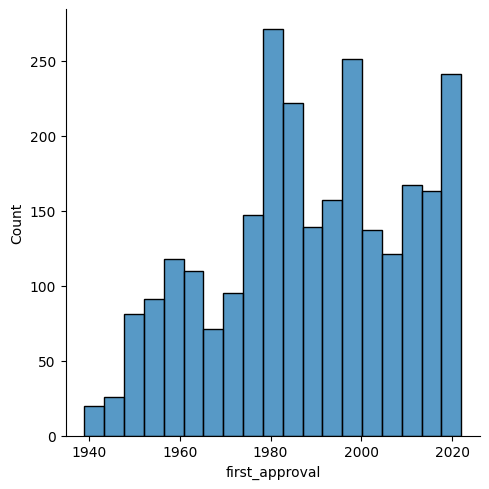

In [ ]:
sns.displot(x='first_approval', data=df)

We want to compile the drugs data from df to our final_df.

In [ ]:
final_df.columns

Index(['Name', 'Smiles', 'pIC50', 'activity', 'dataset'], dtype='object')

In [ ]:
# In a new dataframe, we only keep the names and SMILEs.
df_1 = df[['pref_name', 'smiles']]

# We need to add 2 more columns:
df_1.loc[:,'activity'] = ['unknown' for _ in range(len(df_1))] # As we don't know the activity on CETP yet.
df_1.loc[:,'dataset'] = ['FDA' for _ in range(len(df_1))] # To understand wether our new condidtaes for this usage are former drugs or not, we determine the dataset for each data.


<ipython-input-13-1198394689>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1.loc[:,'activity'] = ['unknown' for _ in range(len(df_1))] # As we don't know the activity on CETP yet.
<ipython-input-13-1198394689>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1.loc[:,'dataset'] = ['FDA' for _ in range(len(df_1))] # To understand wether our new condidtaes for this usage are former drugs or not, we determine the dataset for each data.


In [ ]:
df_1.rename(columns={"pref_name":"Name", "smiles":"Smiles"}, inplace=True)

<ipython-input-14-1404674365>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1.rename(columns={"pref_name":"Name", "smiles":"Smiles"}, inplace=True)


In [ ]:
# Finally, we combine these two dataframes.
col_name = df_1.columns
df_combine = pd.concat([final_df[col_name], df_1], axis=0).reset_index(drop=True)

In [ ]:
df_combine

,Name,Smiles,activity,dataset
0,CHEMBL604308,O=C(COc1ccc(C(F)(F)F)cc1)Nc1ccc(-c2nc3cc(Cl)cc...,inactive,train
1,CHEMBL341275,COC(=O)c1cccc(CN(CC(O)C(F)(F)F)c2cccc(Oc3ccccc...,inactive,train
2,CHEMBL259005,Cc1cc(C)c2oc(-c3ccc(NC(=O)COc4cccc(C#N)c4)cc3)...,inactive,train
3,CHEMBL2032421,CC(C)OC(=O)N1c2ccc(C(F)(F)F)cc2[C@@H](N(Cc2cc(...,active,train
4,CHEMBL4864315,COc1ncc(-c2ccc(C(=O)O)cc2C)cc1-c1cc(C(F)(F)F)c...,active,train
...,...,...,...,...
4037,AMPHETAMINE ASPARTATE/DEXTROAMPHETAMINE SULFATE,CC(N)Cc1ccccc1.C[C@H](N)Cc1ccccc1.C[C@H](N)Cc1...,unknown,FDA
4038,PACRITINIB CITRATE,C1=C/COCc2cc(ccc2OCCN2CCCC2)Nc2nccc(n2)-c2cccc...,unknown,FDA
4039,FINGOLIMOD LAURYL SULFATE,CCCCCCCCCCCCOS(=O)(=O)O.CCCCCCCCc1ccc(CCC(N)(C...,unknown,FDA
4040,VENLAFAXINE BESYLATE,COc1ccc(C(CN(C)C)C2(O)CCCCC2)cc1.O=S(=O)(O)c1c...,unknown,FDA


In [ ]:
mols = df_combine['Smiles'].apply(Chem.MolFromSmiles)
fingerprint_dic = calculate_fingerprint(mols)

[09:10:32] WARNING: not removing hydrogen atom without neighbors
[09:10:32] WARNING: not removing hydrogen atom without neighbors
[09:10:32] WARNING: not removing hydrogen atom without neighbors
[09:10:32] WARNING: not removing hydrogen atom without neighbors


In [ ]:
PubChem = fingerprint_dic['PubChem']
ECFP = fingerprint_dic['ECFP']
rdkit_dec = fingerprint_dic['rdkit-dec']
Map4 = fingerprint_dic['Map4']

In [ ]:
rdkit_dec.columns = [f'rdkit_{i}' for i in rdkit_dec.columns]

In [ ]:
df_all = pd.concat([df_combine, ECFP, PubChem,rdkit_dec, Map4], axis=1)

In [ ]:
# To store it somewhere outside google!
df_all.to_csv("data with all feature.csv", index=False)

In [ ]:
# creating separate pandas DataFrames, each containing features derived from a specific type of molecular fingerprint calculation.
x_rdkit = df_all.filter(regex='rdkit_') # select all columns whose names contain the string 'rdkit_'.
x_ECFP = df_all.filter(regex='ecfp')
x_pubchem = df_all.filter(regex='pubchem')
x_map = df_all.filter(regex='map')

In [ ]:
list_df = [x_ECFP, x_pubchem, x_rdkit, x_map]

for i in range(len(list_df)):
    list_df[i] = pd.concat([df_all[['Name', 'Smiles', 'activity', 'dataset']], list_df[i]], axis=1)

x_ECFP, x_pubchem, x_rdkit, x_map = list_df

In [ ]:
# To see all features from different descriptors.
df_all

,Name,Smiles,activity,dataset,ecfpfingerprint0,ecfpfingerprint1,ecfpfingerprint2,ecfpfingerprint3,ecfpfingerprint4,ecfpfingerprint5,...,mapfingerprint2038,mapfingerprint2039,mapfingerprint2040,mapfingerprint2041,mapfingerprint2042,mapfingerprint2043,mapfingerprint2044,mapfingerprint2045,mapfingerprint2046,mapfingerprint2047
0,CHEMBL604308,O=C(COc1ccc(C(F)(F)F)cc1)Nc1ccc(-c2nc3cc(Cl)cc...,inactive,train,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
1,CHEMBL341275,COC(=O)c1cccc(CN(CC(O)C(F)(F)F)c2cccc(Oc3ccccc...,inactive,train,0,1,0,0,0,0,...,1,1,0,0,0,0,0,1,0,1
2,CHEMBL259005,Cc1cc(C)c2oc(-c3ccc(NC(=O)COc4cccc(C#N)c4)cc3)...,inactive,train,0,0,0,0,0,0,...,1,1,1,0,0,0,0,1,0,0
3,CHEMBL2032421,CC(C)OC(=O)N1c2ccc(C(F)(F)F)cc2[C@@H](N(Cc2cc(...,active,train,0,1,0,0,0,0,...,1,1,0,0,0,0,0,1,0,1
4,CHEMBL4864315,COc1ncc(-c2ccc(C(=O)O)cc2C)cc1-c1cc(C(F)(F)F)c...,active,train,0,0,0,0,0,0,...,1,1,1,1,1,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4037,AMPHETAMINE ASPARTATE/DEXTROAMPHETAMINE SULFATE,CC(N)Cc1ccccc1.C[C@H](N)Cc1ccccc1.C[C@H](N)Cc1...,unknown,FDA,0,1,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
4038,PACRITINIB CITRATE,C1=C/COCc2cc(ccc2OCCN2CCCC2)Nc2nccc(n2)-c2cccc...,unknown,FDA,0,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,0
4039,FINGOLIMOD LAURYL SULFATE,CCCCCCCCCCCCOS(=O)(=O)O.CCCCCCCCc1ccc(CCC(N)(C...,unknown,FDA,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4040,VENLAFAXINE BESYLATE,COc1ccc(C(CN(C)C)C2(O)CCCCC2)cc1.O=S(=O)(O)c1c...,unknown,FDA,0,1,1,0,0,0,...,1,1,0,0,0,0,0,0,0,0


In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import recall_score, precision_score, f1_score, matthews_corrcoef
import numpy as np

mapping = {'active': 1, 'inactive': 0}

if 'activity' in df_all.columns:
    df_all['activity'] = df_all['activity'].map(mapping)

fingerprint_names = [
    'x_ECFP',  'x_pubchem', 'x_rdkit' , 'x_map'
]
fingerprint_dfs = [x_ECFP,  x_pubchem, x_rdkit, x_map]

for df_fp in fingerprint_dfs:
    if 'activity' in df_fp.columns:
        df_fp['activity'] = df_fp['activity'].map(mapping)

We need high precision to be sure what we are finding would really work!

In [ ]:
results = []

for name, df_fp in zip(fingerprint_names, fingerprint_dfs):
    # Filtering train data
    train_df = df_fp[df_fp['dataset'] == 'train']

     # It checks if there are at least 10 samples in the training data.
    if len(train_df) < 10:
        print(f"Not enough data for {name}")
        continue

    X = train_df.drop(columns=['Name', 'Smiles', 'activity', 'dataset'])
    y = train_df['activity']

    # It checks if both classes ('active' and 'inactive') are present in the target variable (y).
    # Stratified cross-validation requires at least two classes.
    if len(np.unique(y)) < 2:
        print(f"Not both classes ('active' and 'inactive') are present in {name}")
        continue

     # It checks if there are any features left after dropping the non-feature columns.
    if X.shape[1] == 0:
        print(f"There is no feature for {name}")
        continue

     # Stratified K-Fold ensures that each fold has approximately the same percentage of samples of each target class as the complete dataset.
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    recalls, precisions, f1s, mccs = [], [], [], []

    try:
        for train_idx, val_idx in skf.split(X, y):
            X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]

            model = RandomForestClassifier(random_state=42, n_estimators=100)
            model.fit(X_tr, y_tr)
            y_pred = model.predict(X_val)

            recalls.append(recall_score(y_val, y_pred))
            precisions.append(precision_score(y_val, y_pred))
            f1s.append(f1_score(y_val, y_pred))
            mccs.append(matthews_corrcoef(y_val, y_pred))

        results.append({
            'Fingerprint': name,
            'Recall': np.mean(recalls),
            'Precision': np.mean(precisions),
            'F1-score': np.mean(f1s),
            'MCC': np.mean(mccs),
            'Recall_std': np.std(recalls),
            'Precision_std': np.std(precisions),
            'F1_std': np.std(f1s),
            'MCC_std': np.std(mccs)
        })

    except Exception as e:
        print(f"Error in the processing{name}: {e}")

# Display comparison results
results_df = pd.DataFrame(results)
print("\n===  Fingerprints' comparison results ===")

# Training the final model with all features
print("\n=== Training the final model with all features ===")

In [ ]:
results_df

,Fingerprint,Recall,Precision,F1-score,MCC,Recall_std,Precision_std,F1_std,MCC_std
0,x_ECFP,0.659544,0.704174,0.679483,0.530127,0.054547,0.029069,0.031526,0.038141
1,x_pubchem,0.646105,0.681801,0.661904,0.501730,0.037679,0.034212,0.015911,0.024643
2,x_rdkit,0.648912,0.726167,0.685291,0.543356,0.024992,0.021194,0.022442,0.031626
3,x_map,0.600982,0.740342,0.662335,0.525761,0.033510,0.025442,0.016460,0.017572


<Figure size 1600x1200 with 0 Axes>

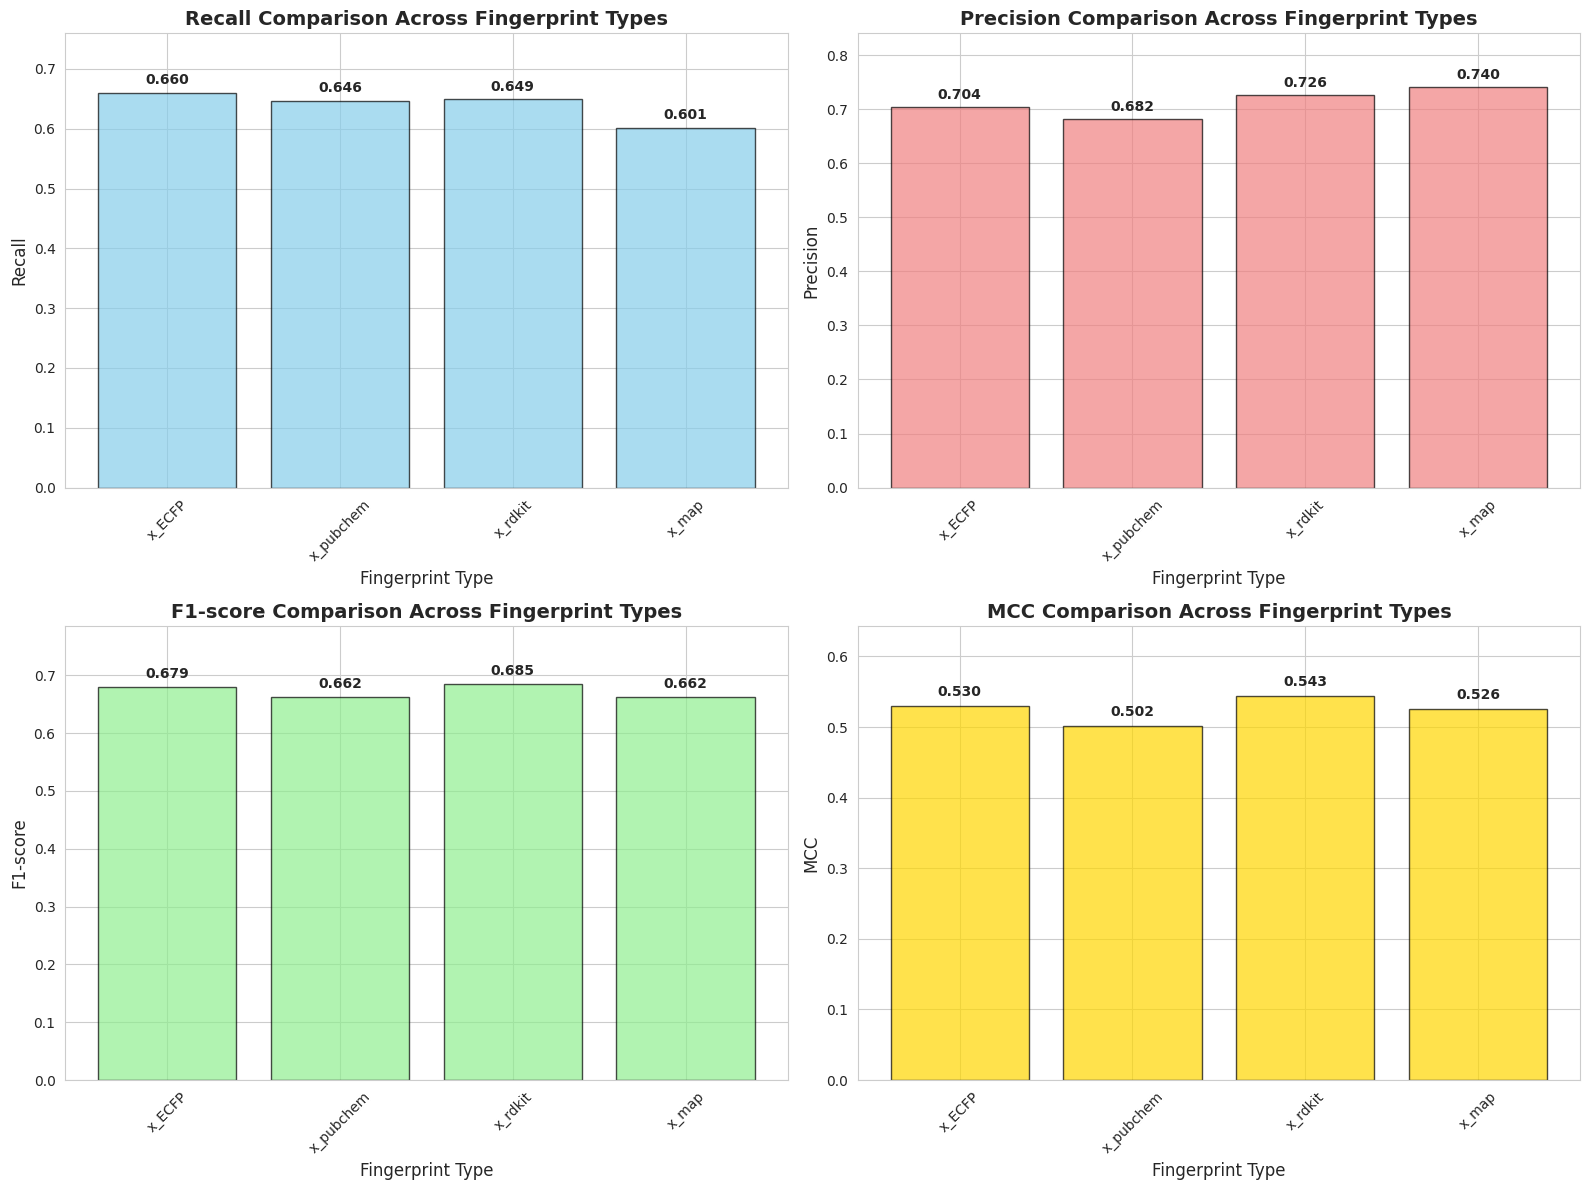

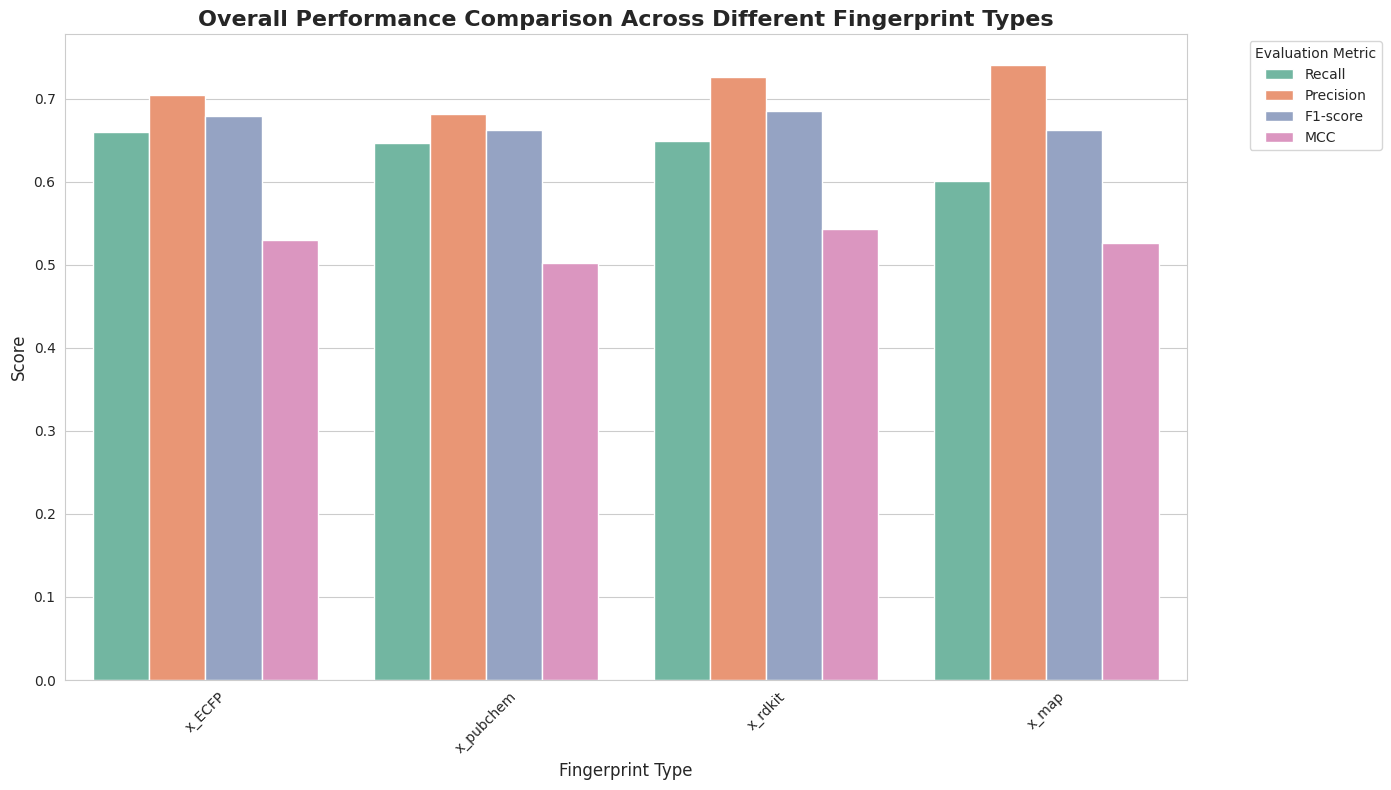

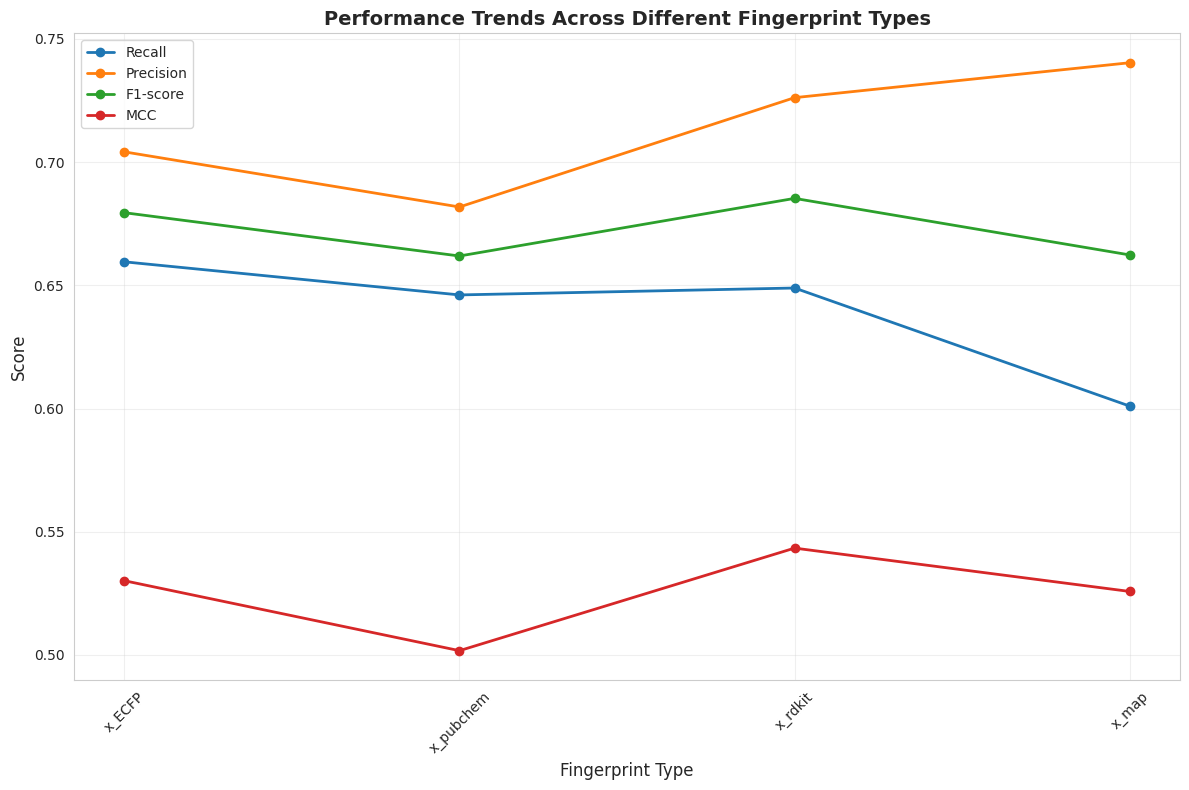

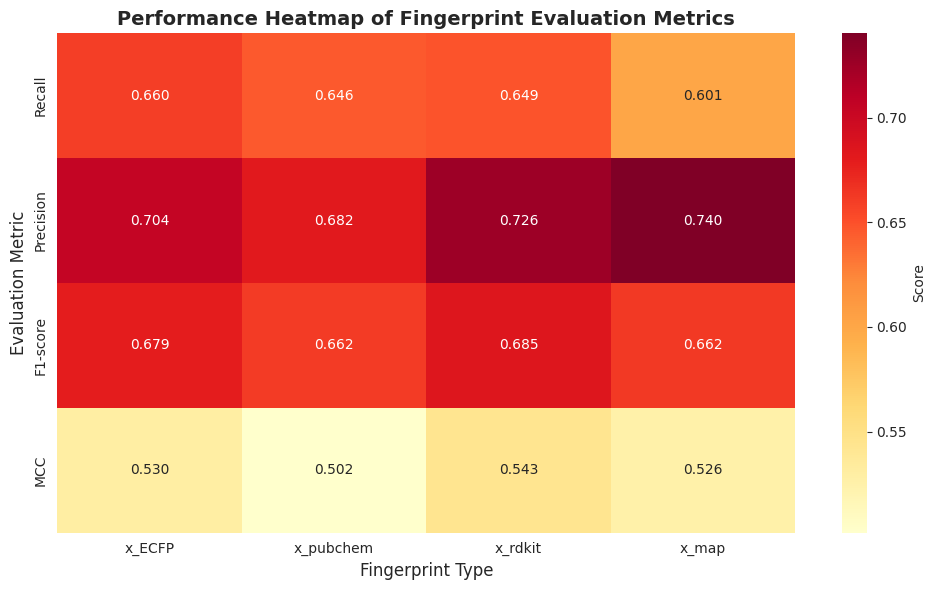

=== Results Summary ===
Fingerprint  Recall  Precision  F1-score    MCC  Recall_std  Precision_std  F1_std  MCC_std
     x_ECFP  0.6595     0.7042    0.6795 0.5301      0.0545         0.0291  0.0315   0.0381
  x_pubchem  0.6461     0.6818    0.6619 0.5017      0.0377         0.0342  0.0159   0.0246
    x_rdkit  0.6489     0.7262    0.6853 0.5434      0.0250         0.0212  0.0224   0.0316
      x_map  0.6010     0.7403    0.6623 0.5258      0.0335         0.0254  0.0165   0.0176

=== Best Fingerprint for Each Metric ===
Recall: x_ECFP (0.6595)
Precision: x_map (0.7403)
F1-score: x_rdkit (0.6853)
MCC: x_rdkit (0.5434)

=== Overall Performance Ranking ===
1. x_rdkit: 0.6509
2. x_ECFP: 0.6433
3. x_map: 0.6324
4. x_pubchem: 0.6229


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Chart settings
plt.rcParams['font.family'] = 'DejaVu Sans'
sns.set_style("whitegrid")
plt.figure(figsize=(16, 12))

# Bar charts for each metric
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
metrics = ['Recall', 'Precision', 'F1-score', 'MCC']
colors = ['skyblue', 'lightcoral', 'lightgreen', 'gold']

for i, (ax, metric, color) in enumerate(zip(axes.flatten(), metrics, colors)):
    bars = ax.bar(results_df['Fingerprint'], results_df[metric], color=color, alpha=0.7, edgecolor='black')

    # Add values on bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.3f}', ha='center', va='bottom', fontweight='bold')

    ax.set_title(f'{metric} Comparison Across Fingerprint Types', fontsize=14, fontweight='bold')
    ax.set_ylim(0, max(results_df[metric]) + 0.1)
    ax.set_xlabel('Fingerprint Type', fontsize=12)
    ax.set_ylabel(metric, fontsize=12)
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Overall comparison chart (all metrics in one chart)
plt.figure(figsize=(14, 8))

# Convert data to appropriate format for grouped bar chart
metrics_data = results_df.melt(id_vars=['Fingerprint'],
                              value_vars=['Recall', 'Precision', 'F1-score', 'MCC'],
                              var_name='Metric', value_name='Score')

# Grouped bar chart
sns.barplot(data=metrics_data, x='Fingerprint', y='Score', hue='Metric', palette='Set2')
plt.title('Overall Performance Comparison Across Different Fingerprint Types', fontsize=16, fontweight='bold')
plt.xlabel('Fingerprint Type', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Evaluation Metric', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Line chart for trend comparison
plt.figure(figsize=(12, 8))
for metric in ['Recall', 'Precision', 'F1-score', 'MCC']:
    plt.plot(results_df['Fingerprint'], results_df[metric], marker='o', linewidth=2, label=metric)

plt.title('Performance Trends Across Different Fingerprint Types', fontsize=14, fontweight='bold')
plt.xlabel('Fingerprint Type', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.xticks(rotation=45)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Heatmap for better comparison
plt.figure(figsize=(10, 6))
heatmap_data = results_df.set_index('Fingerprint')[['Recall', 'Precision', 'F1-score', 'MCC']]
sns.heatmap(heatmap_data.T, annot=True, cmap='YlOrRd', fmt='.3f', cbar_kws={'label': 'Score'})
plt.title('Performance Heatmap of Fingerprint Evaluation Metrics', fontsize=14, fontweight='bold')
plt.xlabel('Fingerprint Type', fontsize=12)
plt.ylabel('Evaluation Metric', fontsize=12)
plt.tight_layout()
plt.show()

# Results summary table
print("=== Results Summary ===")
print(results_df.round(4).to_string(index=False))

# Find best fingerprint for each metric
print("\n=== Best Fingerprint for Each Metric ===")
for metric in ['Recall', 'Precision', 'F1-score', 'MCC']:
    best_fp = results_df.loc[results_df[metric].idxmax(), 'Fingerprint']
    best_score = results_df[metric].max()
    print(f"{metric}: {best_fp} ({best_score:.4f})")

# Performance ranking
print("\n=== Overall Performance Ranking ===")
results_df['Average_Score'] = results_df[['Recall', 'Precision', 'F1-score', 'MCC']].mean(axis=1)
ranking = results_df.sort_values('Average_Score', ascending=False)[['Fingerprint', 'Average_Score']]
for i, (idx, row) in enumerate(ranking.iterrows(), 1):
    print(f"{i}. {row['Fingerprint']}: {row['Average_Score']:.4f}")


## Train model

First, we filter the features.

In [ ]:
# correlation_threshold is used to address multicollinearity,  representing the maximum absolute correlation allowed between two features.
# More correlation_threshold shows that we want to lose less features as we allow more similarity between features.
# variance_threshold=0.01 representing the minimum variance a feature must have to be kept.
def filter_features(df, feature_diff,variance_threshold=0.01, correlation_threshold=0.8):
    FEATURES = df.columns.difference(feature_diff).tolist()
    features = df[FEATURES]


    # انتخاب ستون‌های عددی
    numerical_features = features.select_dtypes(include=[np.number])

    # حذف ستون‌های با واریانس کمتر از آستانه
    selector = VarianceThreshold(threshold=variance_threshold)
    numerical_array = selector.fit_transform(numerical_features)
    selected_columns = numerical_features.columns[selector.get_support()].tolist()
    numerical_features = pd.DataFrame(
        numerical_array,
        index=numerical_features.index,
        columns=selected_columns
    )

    # حذف ویژگی‌های با همبستگی بالا
    corr_matrix = numerical_features.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > correlation_threshold)]
    numerical_features = numerical_features.drop(columns=to_drop)

    # بازگرداندن سایر ویژگی‌ها (غیر عددی) به همراه ویژگی‌های عددی فیلترشده
    non_numerical_features = features.select_dtypes(exclude=[np.number])
    filtered_df = pd.concat([non_numerical_features, numerical_features], axis=1)

    return filtered_df


In [ ]:
# XGBoost Cross-Validation Function

SEED = 101 #Using a fixed random seed ensures that the data splitting for cross-validation is the same each time you run the code, making your results reproducible.

def perform_xgb_cv(dtrain, params, additional_info=None, seed=SEED):
    """
    Performs cross-validation using XGBoost with specified parameters.

    Parameters:
    - dtrain (xgb.DMatrix): The training data in XGBoost DMatrix format.
    - params (dict): A dictionary of parameters for the XGBoost model.
    - additional_info (dict, optional): Additional information to include in the result.
    - seed (int): Random seed for reproducibility of cross-validation.

    Returns:
    - dict: A dictionary containing the best RMSE, MAE, best iteration, and additional info.

    The function works by:
    1. Running XGBoost cross-validation with 5 folds and early stopping.
    2. Identifying the best iteration based on the minimum RMSE.
    3. Returning the best parameters and metrics along with any additional info provided.
    """
    cv = xgb.cv(
        params=params,
        dtrain=dtrain,
        num_boost_round=5000,
        nfold=5,
        metrics=['auc', 'aucpr', 'logloss'],
        seed=seed,
        early_stopping_rounds=50
    )
    best_iter = cv['test-aucpr-mean'].idxmax()

    result = {
        **params,
        'best_aucpr': cv['test-aucpr-mean'].max(),
        'auc': cv.loc[best_iter, 'test-auc-mean'],
        'best_iteration': best_iter,
        'params': params
    }
    if additional_info:
        result.update(additional_info)

    return result

In [ ]:
feature_diff = ['Name', 'Smiles', 'activity', 'dataset'] # To select the primary info of each drug, we need this list.

feature_filtter = filter_features(df_all, feature_diff)

In [ ]:
feature_diff

['Name', 'Smiles', 'activity', 'dataset']

In [ ]:
# putting back the non-feature columns (like name, SMILES string, activity, and dataset identifier) alongside the numerical features that were kept after the filtering process.
# This creates a comprehensive dataframe that includes both the key identifying information and the processed numerical features that will be used for training the model.
all_feature_filtered = pd.concat([df_all[feature_diff], feature_filtter], axis=1)


In [ ]:
# Variable Definitions and Model Parameters

TARGET_COL = 'target'
BIO_CLASS = 'class'
DATASET_COL = 'dataset'
NAME_COL = 'molecule_chembl_id'

# hyperparameters for an XGBoost classifier model
params = {
    # Learning rate & regularization
    'eta': [0.01],
    'alpha': [0.01],
    'lambda': [10],

    # Tree structure
    'max_depth': [4],
    'min_child_weight': [4],
    'gamma': [0],

    # Sampling
    'subsample': [0.6],
    'colsample_bytree': [0.5],
    'colsample_bynode': [0.3],

    }


params = list(ParameterGrid(params))
len(params)


1

**Hyperparameters for an XGBoost classifier model**

*   **'eta'**: This is the learning rate, which controls how quickly the model learns. A smaller value means slower learning but can lead to a more robust model.    
  *   **'alpha' and 'lambda'**: These are regularization parameters (L1 and L2 respectively) that help prevent overfitting by penalizing large coefficients.  
*   **'max_depth'**: This limits the maximum depth of each tree in the model.  
*  **'min_child_weight'**: This defines the minimum sum of instance weight (hessian) needed in a child. A larger value prevents the model from learning relations specific to a small number of observations.  
*  **'gamma'**: This specifies the minimum loss reduction required to make a further partition on a leaf node of the tree.  
* **'subsample'**: This is the fraction of samples (observations) used to train each tree. Setting it less than 1.0 means that XGBoost randomly samples data points, which can help prevent overfitting.  
*  **'colsample_bytree'**: This is the fraction of features (columns) used when building each tree.  
*  **'colsample_bynode'**: This is the fraction of features used for each split within a node in a tree.  





In [ ]:
%%time

FEATURES = all_feature_filtered.columns.difference(feature_diff).tolist()

dtrain = xgb.DMatrix(
    all_feature_filtered.loc[all_feature_filtered['dataset'] == 'train', FEATURES].values,
    label=all_feature_filtered.loc[all_feature_filtered['dataset'] == 'train', 'activity'].values
    )


cv_results = []
for params_id, train_params in enumerate(params):
        result = perform_xgb_cv(
            dtrain, train_params, additional_info={
            'num_features': dtrain.num_col(),
            'n_dtrain': dtrain.num_row(),
            'params_id': params_id
        })
        cv_results.append(result)

CPU times: user 1min 44s, sys: 862 ms, total: 1min 45s
Wall time: 1min 5s


In [ ]:
res = pd.DataFrame(cv_results)
res.sort_values('best_aucpr', ascending=False)

,alpha,colsample_bynode,colsample_bytree,eta,gamma,lambda,max_depth,min_child_weight,subsample,best_aucpr,auc,best_iteration,params,num_features,n_dtrain,params_id
0,0.01,0.3,0.5,0.01,0,10,4,4,0.6,0.788344,0.86334,629,"{'alpha': 0.01, 'colsample_bynode': 0.3, 'cols...",3267,1131,0


In [ ]:
best_rmse_row = res.loc[res['best_aucpr'].idxmin()]
best_params = best_rmse_row['params']
best_iteration = best_rmse_row['best_iteration']

print("Best params:", best_params)
print("Best iteration:", best_iteration)
print("Best aucpr:", best_rmse_row['best_aucpr'])

Best params: {'alpha': 0.01, 'colsample_bynode': 0.3, 'colsample_bytree': 0.5, 'eta': 0.01, 'gamma': 0, 'lambda': 10, 'max_depth': 4, 'min_child_weight': 4, 'subsample': 0.6}
Best iteration: 629
Best aucpr: 0.7883438558929787


What are the important parts of our target molecules?

In [ ]:
# Shap explains what models are doing and how they think and what features they focus on.
%%time

# Create the dataset for training
FEATURES = all_feature_filtered.columns.difference(feature_diff).tolist()

dtrain = xgb.DMatrix(
    all_feature_filtered.loc[all_feature_filtered['dataset'] == 'train', FEATURES].values,
    label=all_feature_filtered.loc[all_feature_filtered['dataset'] == 'train', 'activity'].values
)

# Convert best_iteration to int if it's float
if isinstance(best_iteration, (float, np.floating)):
    best_iteration_int = int(best_iteration)
else:
    best_iteration_int = best_iteration

print(f"best_iteration type: {type(best_iteration)}")
print(f"best_iteration value: {best_iteration}")
print(f"Converted to int: {best_iteration_int}")

# Train the model with converted iteration count
model = xgb.train(best_params, dtrain, best_iteration_int)

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(dtrain)
feature_importance = np.abs(shap_values).mean(axis=0)

shap_values_storage = {
    'shap_values': feature_importance,
    'feature_names': FEATURES
}

print("Model training completed successfully!")


best_iteration type: <class 'numpy.int64'>
best_iteration value: 629
Converted to int: 629
Model training completed successfully!
CPU times: user 24.8 s, sys: 165 ms, total: 24.9 s
Wall time: 14.7 s


In [ ]:
# Create a new Pandas DataFrame 'shap_df' with two columns:
# - 'feature': populated with the list of feature names from shap_values_storage
# - 'shap_value': populated with the corresponding SHAP values

shap_df = pd.DataFrame({
    'feature': shap_values_storage['feature_names'],
    'shap_value': shap_values_storage['shap_values']
})
shap_df.sort_values(by='shap_value', ascending=False).head(40)

,feature,shap_value
2610,mapfingerprint674,0.015088
9,ecfpfingerprint1019,0.013299
3186,rdkit_Ipc,0.013294
173,ecfpfingerprint1309,0.011999
1485,mapfingerprint1503,0.011494
3209,rdkit_PEOE_VSA7,0.010200
1452,mapfingerprint1474,0.010029
2199,mapfingerprint303,0.009763
3193,rdkit_MolLogP,0.009719
2727,mapfingerprint78,0.009261


In [ ]:
# Filter the DataFrame to rows where 'shap_value' is exactly 0, then get the length (count) of such rows
# This counts features that have no impact on the model's predictions

num_zero_shap = len(shap_df[shap_df['shap_value'] == 0])
print(f"Features with SHAP = 0: {num_zero_shap}")

Features with SHAP = 0: 1080


In [ ]:
# What are the top 3% of our features?
percentiles = [97, 96, 95, 94, 50]
filtered_features = {}

#'filtered_features' dictionary:
# - 'threshold' is the key (e.g., a SHAP threshold value for feature filtering)
# - 'selected_features' is the value (list of feature names selected at that threshold)

shap_values = np.array(shap_values_storage['shap_values'])
feature_names = shap_values_storage['feature_names']
shap_thresholds = np.percentile(shap_values, percentiles)

for threshold, percentile in zip(shap_thresholds, percentiles):
    features_above_threshold = [
        feature_names[i] for i, val in enumerate(shap_values)
        if val > threshold
    ]
    filtered_features[percentile] = features_above_threshold
    print((
        f"Percentile: {percentile}, "
        f"Number of features: {len(features_above_threshold)}"
    ))

Percentile: 97, Number of features: 98
Percentile: 96, Number of features: 131
Percentile: 95, Number of features: 164
Percentile: 94, Number of features: 196
Percentile: 50, Number of features: 1633


In [ ]:
%%time
# This is a Jupyter Notebook magic command that measures the execution time of the entire code cell.


# Initialize an empty list to store cross-validation results for each threshold
cv_results = []

# Loop over each item in 'filtered_features' dictionary:
# - 'threshold' is the key (e.g., a SHAP threshold value for feature filtering)
# - 'selected_features' is the value (list of feature names selected at that threshold)
for threshold, selected_features in filtered_features.items():
    dtrain = xgb.DMatrix(
        all_feature_filtered.loc[all_feature_filtered['dataset'] == 'train', selected_features].values,
        label=all_feature_filtered.loc[all_feature_filtered['dataset'] == 'train', 'activity'].values
        )

# Call a custom function 'perform_xgb_cv' to run cross-validation on the DMatrix:
    # - Passes 'dtrain', best hyperparameters 'best_params'
    # - Includes additional info as a dict: number of features, number of training rows, and the threshold
    # - The function likely returns CV metrics like AUC, accuracy, etc.
    result = perform_xgb_cv(
        dtrain, best_params, additional_info={
            'num_features': dtrain.num_col(), # Get the number of columns (features) in DMatrix
            'n_dtrain': dtrain.num_row(), # Get the number of rows (samples) in DMatrix
            'threshold': threshold # Store the threshold for reference in results
        })
    cv_results.append(result)

CPU times: user 2min 8s, sys: 1.17 s, total: 2min 9s
Wall time: 1min 16s


It shows the best threshold of our top features which leads to a better model.  
The top row is our best one!

In [ ]:
# Sorting thresholds by best_aucpr. 
columns = ['threshold', 'best_aucpr', 'auc', 'best_iteration', 'num_features', 'n_dtrain']
res = pd.DataFrame(cv_results)[columns]
res.sort_values(by='best_aucpr', ascending=False)

,threshold,best_aucpr,auc,best_iteration,num_features,n_dtrain
1,96,0.817790,0.885202,922,131,1131
0,97,0.813576,0.883900,814,98,1131
3,94,0.808547,0.880156,553,196,1131
2,95,0.800142,0.877158,385,164,1131
4,50,0.789609,0.867673,658,1633,1131


In [ ]:
best_auc_row = res.loc[res['best_aucpr'].idxmax()]
best_threshold = best_auc_row['threshold']
print("Best threshold:", best_threshold)

Best threshold: 96.0


In [ ]:
# Here we finally select our best features which can lead to the best model.
select_fetu = df_all[filtered_features[best_threshold]]

In [ ]:
select_fetu.filter(regex='ecfp')

,ecfpfingerprint1019,ecfpfingerprint1050,ecfpfingerprint1084,ecfpfingerprint1309,ecfpfingerprint1487,ecfpfingerprint1765,ecfpfingerprint1920,ecfpfingerprint724,ecfpfingerprint877
0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0
3,1,0,0,1,0,0,0,0,0
4,1,0,1,1,1,1,0,1,0
...,...,...,...,...,...,...,...,...,...
4037,0,0,0,0,0,0,0,0,0
4038,0,0,0,0,0,0,0,0,0
4039,0,0,0,0,0,0,0,0,0
4040,0,0,0,0,0,0,0,0,0


In [ ]:
select_fetu

,ecfpfingerprint1019,ecfpfingerprint1050,ecfpfingerprint1084,ecfpfingerprint1309,ecfpfingerprint1487,ecfpfingerprint1765,ecfpfingerprint1920,ecfpfingerprint724,ecfpfingerprint877,mapfingerprint1038,...,rdkit_PEOE_VSA8,rdkit_PEOE_VSA9,rdkit_SMR_VSA1,rdkit_SMR_VSA3,rdkit_SMR_VSA6,rdkit_SlogP_VSA4,rdkit_VSA_EState2,rdkit_VSA_EState5,rdkit_VSA_EState7,rdkit_VSA_EState8
0,0,0,0,0,0,0,0,0,0,0,...,16.273472,5.563451,27.119797,4.983979,11.923671,0.000000,16.446600,0.124531,-4.423603,-0.348210
1,0,0,0,0,0,0,0,0,0,0,...,18.298510,19.218006,32.546036,0.000000,18.554464,0.000000,13.189133,0.465556,-7.324485,-0.673108
2,0,0,0,0,0,0,0,0,0,1,...,11.250837,11.632673,13.948551,4.983979,11.923671,25.178587,16.725416,0.718885,0.000000,3.879136
3,1,0,0,1,0,0,0,0,0,0,...,12.586597,41.571220,49.045135,20.207254,9.799819,5.917906,16.826496,-0.324725,-15.090106,2.554816
4,1,0,1,1,1,1,0,1,0,0,...,22.887197,49.190475,68.419930,14.867867,14.219595,6.923737,33.796486,-2.287084,-16.917070,2.216469
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4037,0,0,0,0,0,0,0,0,0,0,...,18.125523,6.420822,37.325424,0.000000,0.000000,0.000000,19.617268,-2.497870,2.386759,6.062500
4038,0,0,0,0,0,0,0,0,0,1,...,29.555889,44.963100,49.020309,14.867867,44.771702,0.000000,42.098755,-3.624703,6.044494,5.988914
4039,0,0,0,0,0,0,0,0,0,1,...,0.000000,25.359571,27.366688,0.000000,19.820646,0.000000,0.000000,0.000000,22.361940,4.195031
4040,0,0,0,0,0,0,0,0,0,1,...,12.462663,17.606333,22.813938,4.899909,27.749897,0.000000,2.094055,1.038605,5.349052,0.877806


In [ ]:
df_all

,Name,Smiles,activity,dataset,ecfpfingerprint0,ecfpfingerprint1,ecfpfingerprint2,ecfpfingerprint3,ecfpfingerprint4,ecfpfingerprint5,...,mapfingerprint2038,mapfingerprint2039,mapfingerprint2040,mapfingerprint2041,mapfingerprint2042,mapfingerprint2043,mapfingerprint2044,mapfingerprint2045,mapfingerprint2046,mapfingerprint2047
0,CHEMBL604308,O=C(COc1ccc(C(F)(F)F)cc1)Nc1ccc(-c2nc3cc(Cl)cc...,0.0,train,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
1,CHEMBL341275,COC(=O)c1cccc(CN(CC(O)C(F)(F)F)c2cccc(Oc3ccccc...,0.0,train,0,1,0,0,0,0,...,1,1,0,0,0,0,0,1,0,1
2,CHEMBL259005,Cc1cc(C)c2oc(-c3ccc(NC(=O)COc4cccc(C#N)c4)cc3)...,0.0,train,0,0,0,0,0,0,...,1,1,1,0,0,0,0,1,0,0
3,CHEMBL2032421,CC(C)OC(=O)N1c2ccc(C(F)(F)F)cc2[C@@H](N(Cc2cc(...,1.0,train,0,1,0,0,0,0,...,1,1,0,0,0,0,0,1,0,1
4,CHEMBL4864315,COc1ncc(-c2ccc(C(=O)O)cc2C)cc1-c1cc(C(F)(F)F)c...,1.0,train,0,0,0,0,0,0,...,1,1,1,1,1,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4037,AMPHETAMINE ASPARTATE/DEXTROAMPHETAMINE SULFATE,CC(N)Cc1ccccc1.C[C@H](N)Cc1ccccc1.C[C@H](N)Cc1...,NaN,FDA,0,1,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
4038,PACRITINIB CITRATE,C1=C/COCc2cc(ccc2OCCN2CCCC2)Nc2nccc(n2)-c2cccc...,NaN,FDA,0,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,0
4039,FINGOLIMOD LAURYL SULFATE,CCCCCCCCCCCCOS(=O)(=O)O.CCCCCCCCc1ccc(CCC(N)(C...,NaN,FDA,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4040,VENLAFAXINE BESYLATE,COc1ccc(C(CN(C)C)C2(O)CCCCC2)cc1.O=S(=O)(O)c1c...,NaN,FDA,0,1,1,0,0,0,...,1,1,0,0,0,0,0,0,0,0


In [ ]:
# combining the identifying columns from the original df_all DataFrame with the carefully selected and filtered numerical features from the select_fetu DataFrame.
df_selected = pd.concat([df_all[feature_diff], select_fetu], axis=1)

df_selected.to_csv("Dataset with selected features.csv", index=False)

In [ ]:
# Compare our new df_selected dataset to each decriptor

fingerprint_names = [
    'x_ECFP', 'x_pubchem', 'x_rdkit', 'x_map', 'df_new'
]
fingerprint_dfs = [x_ECFP, x_pubchem, x_rdkit, x_map, df_selected]

results = []

# This allows processing each fingerprint type separately.
for name, df_fp in zip(fingerprint_names, fingerprint_dfs):

    # Ignoring the rows with dataset = FDA as these are our test data and we don't want to use them yet.
    train_df = df_fp[df_fp['dataset'] == 'train']

    # Several checks are performed to ensure that the training data is suitable for cross-validation:

    # It checks if there are at least 10 samples in the training data.
    if len(train_df) < 10:
        print(f"Not enough data for {name}")
        continue

    X = train_df.drop(columns=['Name', 'Smiles', 'activity', 'dataset'])
    y = train_df['activity']

    # It checks if both classes ('active' and 'inactive') are present in the target variable (y).
    # Stratified cross-validation requires at least two classes.
    if len(np.unique(y)) < 2:
        print(f"Not both classes ('active' and 'inactive') are present in {name}")
        continue

    # It checks if there are any features left after dropping the non-feature columns.
    if X.shape[1] == 0:
        print(f"There is no feature for {name}")
        continue
    # Stratified K-Fold ensures that each fold has approximately the same percentage of samples of each target class as the complete dataset.
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    recalls, precisions, f1s, mccs = [], [], [], []

    # a try-except block to handle potential errors during the cross-validation process.
    try:
      # the code iterates through the splits generated by StratifiedKFold. For each split, it gets the indices for the training and validation sets.
        for train_idx, val_idx in skf.split(X, y):
            X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]

            model = RandomForestClassifier(random_state=42, n_estimators=100)
            model.fit(X_tr, y_tr)
            y_pred = model.predict(X_val)

            recalls.append(recall_score(y_val, y_pred))
            precisions.append(precision_score(y_val, y_pred))
            f1s.append(f1_score(y_val, y_pred))
            mccs.append(matthews_corrcoef(y_val, y_pred))

        results.append({
            'Fingerprint': name,
            'Recall': np.mean(recalls),
            'Precision': np.mean(precisions),
            'F1-score': np.mean(f1s),
            'MCC': np.mean(mccs),
            'Recall_std': np.std(recalls),
            'Precision_std': np.std(precisions),
            'F1_std': np.std(f1s),
            'MCC_std': np.std(mccs)
        })

    except Exception as e:
        print(f"Error in the processing{name}: {e}")

# Display comparison results
results_df = pd.DataFrame(results)
print("\n=== Fingerprints' comparison results===")

# Training the final model with all features
print("\n=== Training the final model with all features ===")


=== نتایج مقایسه فینگرپرینت‌ها ===

=== آموزش مدل نهایی با تمام فینگرپرینت‌ها ===


In [ ]:
results_df

,Fingerprint,Recall,Precision,F1-score,MCC,Recall_std,Precision_std,F1_std,MCC_std
0,x_ECFP,0.659544,0.704174,0.679483,0.530127,0.054547,0.029069,0.031526,0.038141
1,x_pubchem,0.646105,0.681801,0.661904,0.501730,0.037679,0.034212,0.015911,0.024643
2,x_rdkit,0.648912,0.726167,0.685291,0.543356,0.024992,0.021194,0.022442,0.031626
3,x_map,0.600982,0.740342,0.662335,0.525761,0.033510,0.025442,0.016460,0.017572
4,df_new,0.646281,0.745004,0.690807,0.557835,0.067729,0.032736,0.047946,0.060958


<Figure size 1600x1200 with 0 Axes>

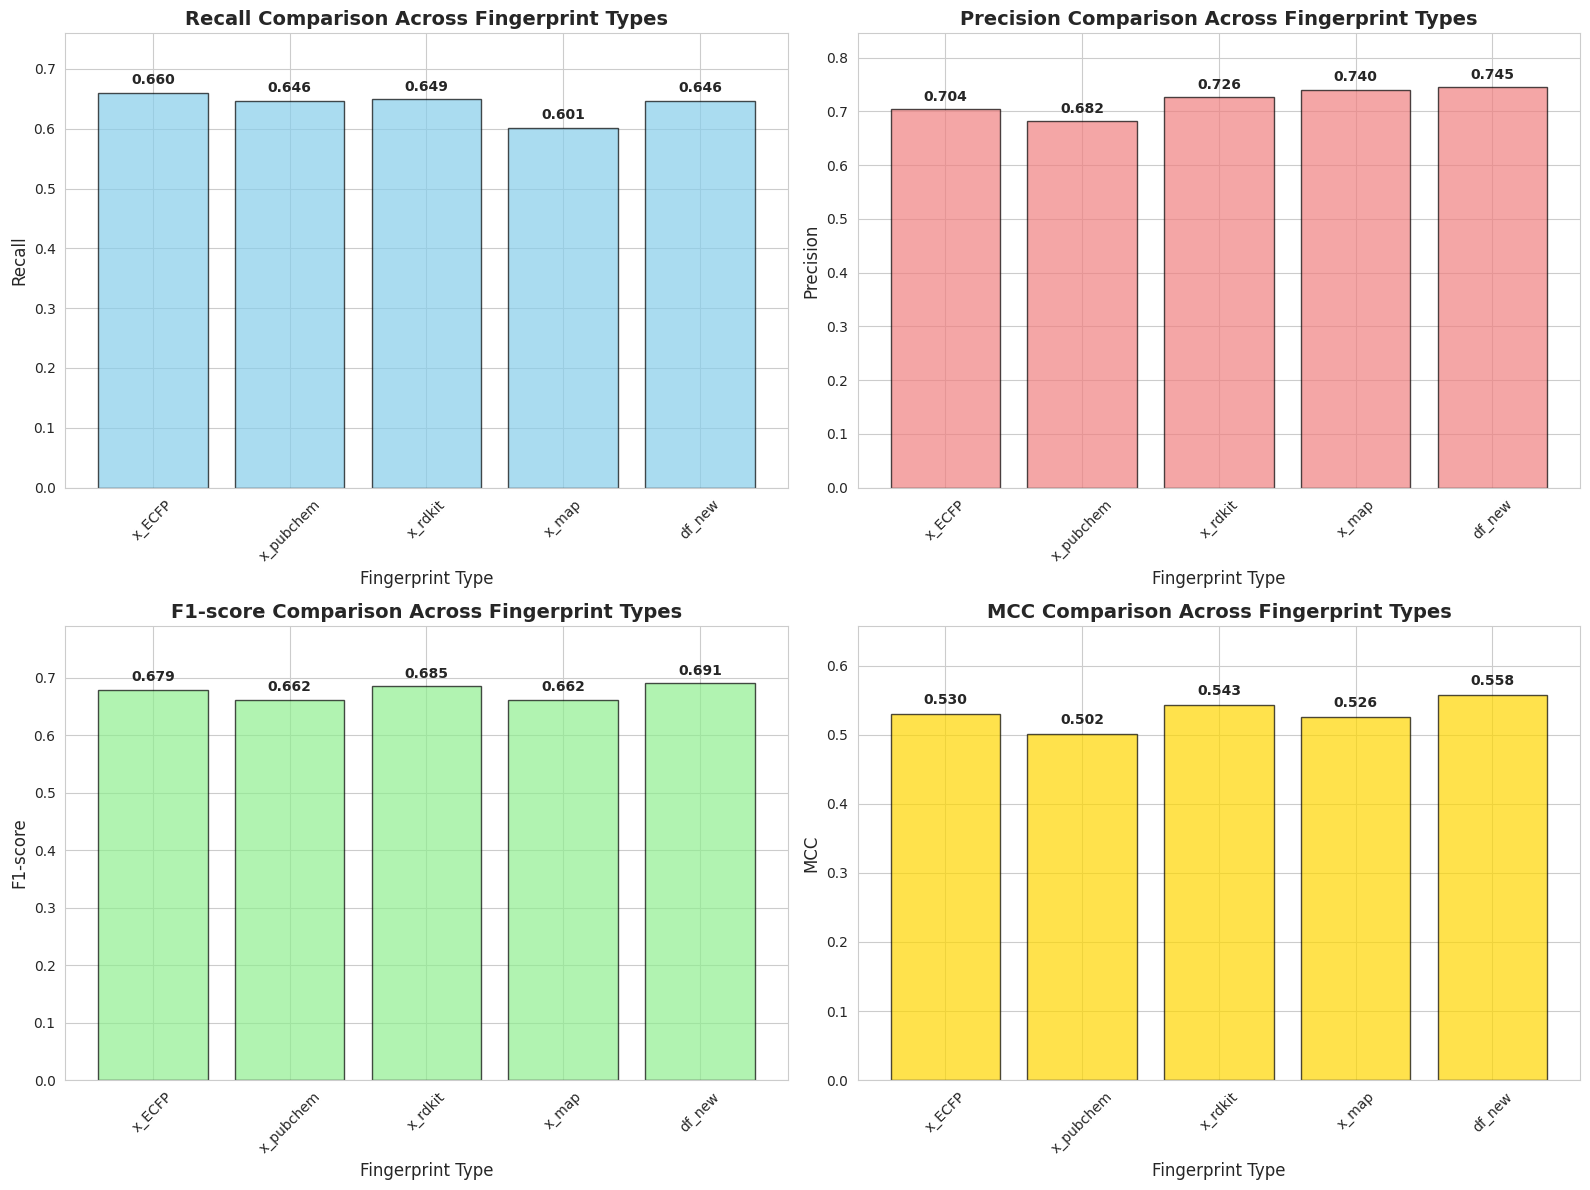

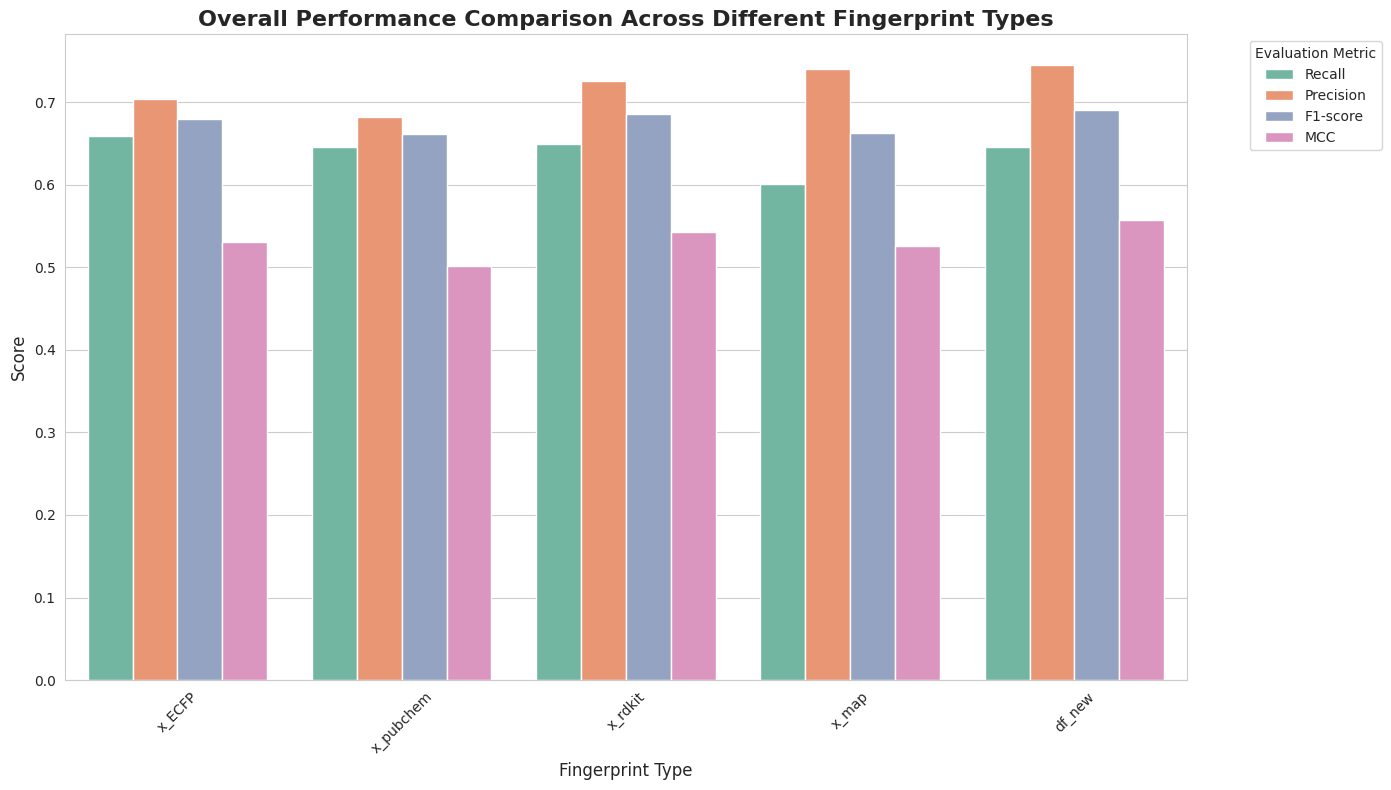

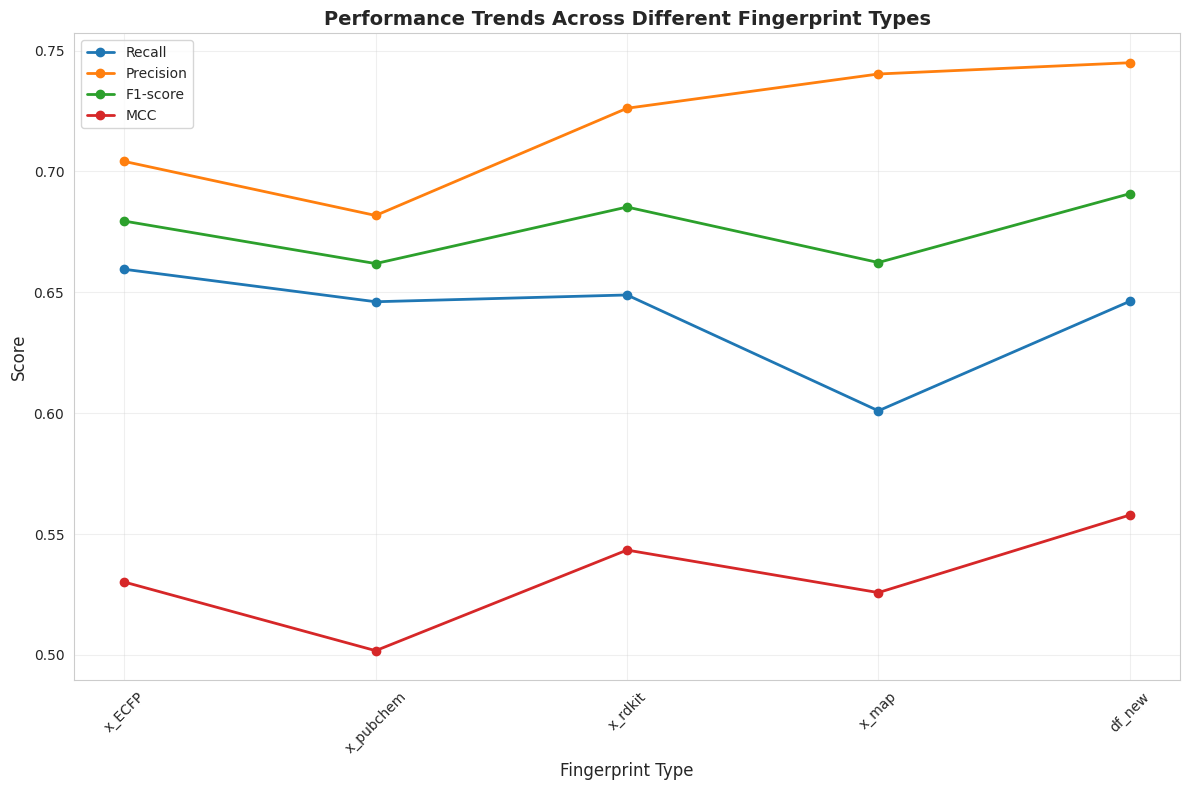

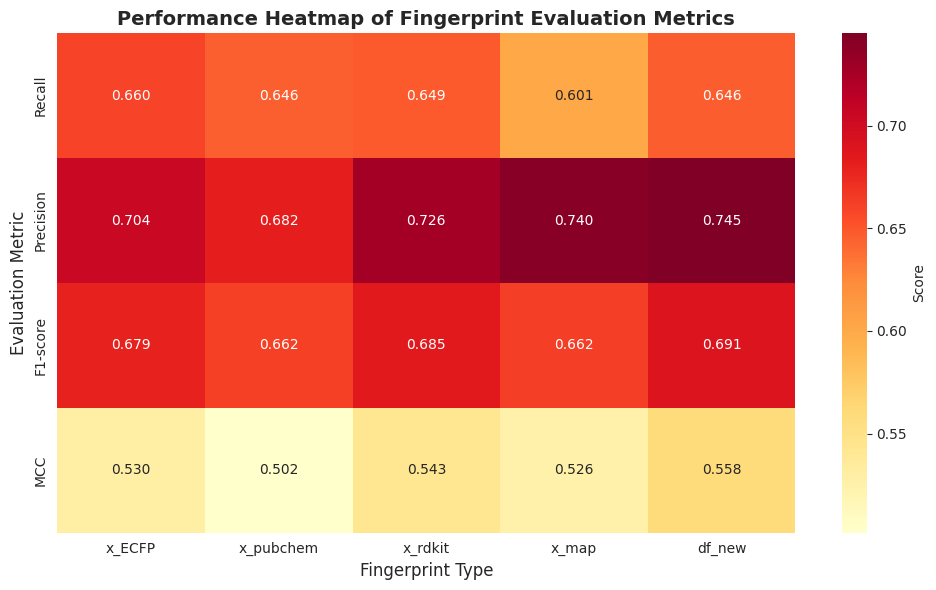

=== Results Summary ===
Fingerprint  Recall  Precision  F1-score    MCC  Recall_std  Precision_std  F1_std  MCC_std
     x_ECFP  0.6595     0.7042    0.6795 0.5301      0.0545         0.0291  0.0315   0.0381
  x_pubchem  0.6461     0.6818    0.6619 0.5017      0.0377         0.0342  0.0159   0.0246
    x_rdkit  0.6489     0.7262    0.6853 0.5434      0.0250         0.0212  0.0224   0.0316
      x_map  0.6010     0.7403    0.6623 0.5258      0.0335         0.0254  0.0165   0.0176
     df_new  0.6463     0.7450    0.6908 0.5578      0.0677         0.0327  0.0479   0.0610

=== Best Fingerprint for Each Metric ===
Recall: x_ECFP (0.6595)
Precision: df_new (0.7450)
F1-score: df_new (0.6908)
MCC: df_new (0.5578)

=== Overall Performance Ranking ===
1. df_new: 0.6600
2. x_rdkit: 0.6509
3. x_ECFP: 0.6433
4. x_map: 0.6324
5. x_pubchem: 0.6229


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Chart settings
plt.rcParams['font.family'] = 'DejaVu Sans'
sns.set_style("whitegrid")
plt.figure(figsize=(16, 12))

# Bar charts for each metric
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
metrics = ['Recall', 'Precision', 'F1-score', 'MCC']
colors = ['skyblue', 'lightcoral', 'lightgreen', 'gold']

for i, (ax, metric, color) in enumerate(zip(axes.flatten(), metrics, colors)):
    bars = ax.bar(results_df['Fingerprint'], results_df[metric], color=color, alpha=0.7, edgecolor='black')

    # Add values on bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.3f}', ha='center', va='bottom', fontweight='bold')

    ax.set_title(f'{metric} Comparison Across Fingerprint Types', fontsize=14, fontweight='bold')
    ax.set_ylim(0, max(results_df[metric]) + 0.1)
    ax.set_xlabel('Fingerprint Type', fontsize=12)
    ax.set_ylabel(metric, fontsize=12)
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Overall comparison chart (all metrics in one chart)
plt.figure(figsize=(14, 8))

# Convert data to appropriate format for grouped bar chart
metrics_data = results_df.melt(id_vars=['Fingerprint'],
                              value_vars=['Recall', 'Precision', 'F1-score', 'MCC'],
                              var_name='Metric', value_name='Score')

# Grouped bar chart
sns.barplot(data=metrics_data, x='Fingerprint', y='Score', hue='Metric', palette='Set2')
plt.title('Overall Performance Comparison Across Different Fingerprint Types', fontsize=16, fontweight='bold')
plt.xlabel('Fingerprint Type', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Evaluation Metric', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Line chart for trend comparison
plt.figure(figsize=(12, 8))
for metric in ['Recall', 'Precision', 'F1-score', 'MCC']:
    plt.plot(results_df['Fingerprint'], results_df[metric], marker='o', linewidth=2, label=metric)

plt.title('Performance Trends Across Different Fingerprint Types', fontsize=14, fontweight='bold')
plt.xlabel('Fingerprint Type', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.xticks(rotation=45)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Heatmap for better comparison
plt.figure(figsize=(10, 6))
heatmap_data = results_df.set_index('Fingerprint')[['Recall', 'Precision', 'F1-score', 'MCC']]
sns.heatmap(heatmap_data.T, annot=True, cmap='YlOrRd', fmt='.3f', cbar_kws={'label': 'Score'})
plt.title('Performance Heatmap of Fingerprint Evaluation Metrics', fontsize=14, fontweight='bold')
plt.xlabel('Fingerprint Type', fontsize=12)
plt.ylabel('Evaluation Metric', fontsize=12)
plt.tight_layout()
plt.show()

# Results summary table
print("=== Results Summary ===")
print(results_df.round(4).to_string(index=False))

# Find best fingerprint for each metric
print("\n=== Best Fingerprint for Each Metric ===")
for metric in ['Recall', 'Precision', 'F1-score', 'MCC']:
    best_fp = results_df.loc[results_df[metric].idxmax(), 'Fingerprint']
    best_score = results_df[metric].max()
    print(f"{metric}: {best_fp} ({best_score:.4f})")

# Performance ranking
print("\n=== Overall Performance Ranking ===")
results_df['Average_Score'] = results_df[['Recall', 'Precision', 'F1-score', 'MCC']].mean(axis=1)
ranking = results_df.sort_values('Average_Score', ascending=False)[['Fingerprint', 'Average_Score']]
for i, (idx, row) in enumerate(ranking.iterrows(), 1):
    print(f"{i}. {row['Fingerprint']}: {row['Average_Score']:.4f}")


In [ ]:
df_selected

,Name,Smiles,activity,dataset,ecfpfingerprint1019,ecfpfingerprint1031,ecfpfingerprint1050,ecfpfingerprint1084,ecfpfingerprint1279,ecfpfingerprint1309,...,rdkit_PEOE_VSA6,rdkit_PEOE_VSA8,rdkit_PEOE_VSA9,rdkit_SMR_VSA6,rdkit_SlogP_VSA1,rdkit_VSA_EState4,rdkit_VSA_EState5,rdkit_VSA_EState7,rdkit_VSA_EState8,rdkit_qed
0,CHEMBL604308,O=C(COc1ccc(C(F)(F)F)cc1)Nc1ccc(-c2nc3cc(Cl)cc...,0.0,train,0,0,0,0,0,0,...,11.600940,16.273472,5.563451,11.923671,10.053652,1.693677,0.124531,-4.423603,-0.348210,0.397074
1,CHEMBL341275,COC(=O)c1cccc(CN(CC(O)C(F)(F)F)c2cccc(Oc3ccccc...,0.0,train,0,0,0,0,0,0,...,36.398201,18.298510,19.218006,18.554464,9.636773,1.281795,0.465556,-7.324485,-0.673108,0.483526
2,CHEMBL259005,Cc1cc(C)c2oc(-c3ccc(NC(=O)COc4cccc(C#N)c4)cc3)...,0.0,train,0,0,0,0,0,0,...,12.132734,11.250837,11.632673,11.923671,10.053652,5.745964,0.718885,0.000000,3.879136,0.511854
3,CHEMBL2032421,CC(C)OC(=O)N1c2ccc(C(F)(F)F)cc2[C@@H](N(Cc2cc(...,1.0,train,1,0,0,0,0,1,...,5.098682,12.586597,41.571220,9.799819,9.799819,-4.613299,-0.324725,-15.090106,2.554816,0.256748
4,CHEMBL4864315,COc1ncc(-c2ccc(C(=O)O)cc2C)cc1-c1cc(C(F)(F)F)c...,1.0,train,1,0,0,1,1,1,...,6.066367,22.887197,49.190475,14.219595,9.473726,-4.598075,-2.287084,-16.917070,2.216469,0.178255
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4037,AMPHETAMINE ASPARTATE/DEXTROAMPHETAMINE SULFATE,CC(N)Cc1ccccc1.C[C@H](N)Cc1ccccc1.C[C@H](N)Cc1...,NaN,FDA,0,0,0,0,0,0,...,90.995506,18.125523,6.420822,0.000000,22.934669,25.661709,-2.497870,2.386759,6.062500,0.157791
4038,PACRITINIB CITRATE,C1=C/COCc2cc(ccc2OCCN2CCCC2)Nc2nccc(n2)-c2cccc...,NaN,FDA,0,0,0,0,0,0,...,30.351141,29.555889,44.963100,44.771702,10.053652,2.139980,-3.624703,6.044494,5.988914,0.207263
4039,FINGOLIMOD LAURYL SULFATE,CCCCCCCCCCCCOS(=O)(=O)O.CCCCCCCCc1ccc(CCC(N)(C...,NaN,FDA,0,0,0,0,0,0,...,128.004440,0.000000,25.359571,19.820646,5.733667,7.628818,0.000000,22.361940,4.195031,0.077885
4040,VENLAFAXINE BESYLATE,COc1ccc(C(CN(C)C)C2(O)CCCCC2)cc1.O=S(=O)(O)c1c...,NaN,FDA,0,0,0,0,0,0,...,49.594299,12.462663,17.606333,27.749897,4.736863,0.653520,1.038605,5.349052,0.877806,0.667892


After finding best features, we can now use our test data which are FDA drugs!  
Here we have some FDA approved drugs but we don't know if they can affect CETP or not.  
Usually we do hyper tuning before using test data.

In [ ]:
model = RandomForestClassifier(random_state=42)
select_fetu = df_all[filtered_features[best_threshold]]
X_train = df_selected.loc[df_selected['dataset']!='FDA', filtered_features[best_threshold]]
y_train = df_selected.loc[df_selected['dataset']!='FDA', 'activity']

In [ ]:
y_train.shape

(1414,)

In [ ]:
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

Number of FDA drugs predicted: 2628
Number of drugs predicted as active: 21.0
Number of drugs predicted as inactive: 2607.0

Sample results:
                Name                                             Smiles  \
1414        PRAZOSIN      COc1cc2nc(N3CCN(C(=O)c4ccco4)CC3)nc(N)c2cc1OC   
1415        NICOTINE                               CN1CCC[C@H]1c1cccnc1   
1416       OFLOXACIN   CC1COc2c(N3CCN(C)CC3)c(F)cc3c(=O)c(C(=O)O)cn1c23   
1417  NALIDIXIC ACID                    CCn1cc(C(=O)O)c(=O)c2ccc(C)nc21   
1418    INDOMETHACIN     COc1ccc2c(c1)c(CC(=O)O)c(C)n2C(=O)c1ccc(Cl)cc1   
1419       SULBACTAM          CC1(C)[C@H](C(=O)O)N2C(=O)C[C@H]2S1(=O)=O   
1420      TAZOBACTAM  C[C@]1(Cn2ccnn2)[C@H](C(=O)O)N2C(=O)C[C@H]2S1(...   
1421   CIPROFLOXACIN         O=C(O)c1cn(C2CC2)c2cc(N3CCNCC3)c(F)cc2c1=O   
1422     NORFLOXACIN          CCn1cc(C(=O)O)c(=O)c2cc(F)c(N3CCNCC3)cc21   
1423     AMPHETAMINE                                     CC(N)Cc1ccccc1   

      predicted_activity  probabi

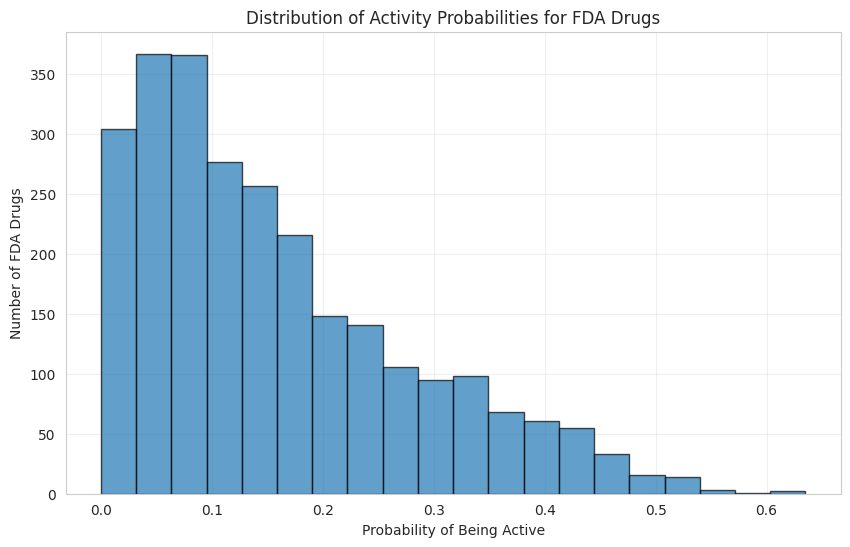

Results saved to fda_predictions.csv
Confidence level analysis:
Confidence >50.0%: 21 active, 2606 inactive
Confidence >60.0%: 2 active, 2482 inactive
Confidence >70.0%: 0 active, 2219 inactive
Confidence >80.0%: 0 active, 1816 inactive
Confidence >90.0%: 0 active, 1043 inactive


In [ ]:
# Prepare FDA data for prediction
X_fda = df_selected.loc[df_selected['dataset'] == 'FDA', filtered_features[best_threshold]]

# Predict class probabilities
y_pred_proba = model.predict_proba(X_fda)

# Predict classes (0 or 1)
y_pred = model.predict(X_fda)

# Create a DataFrame for results
fda_results = df_selected.loc[df_selected['dataset'] == 'FDA', ['Name', 'Smiles']].copy()
fda_results['predicted_activity'] = y_pred
fda_results['probability_inactive'] = y_pred_proba[:, 0]  # Probability of class 0 (inactive)
fda_results['probability_active'] = y_pred_proba[:, 1]    # Probability of class 1 (active)

# Display results
print(f"Number of FDA drugs predicted: {len(fda_results)}")
print(f"Number of drugs predicted as active: {sum(y_pred)}")
print(f"Number of drugs predicted as inactive: {len(y_pred) - sum(y_pred)}")

# Display some sample results
print("\nSample results:")
print(fda_results.head(10))

# Filter drugs predicted as active with high confidence
high_confidence_active = fda_results[
    (fda_results['predicted_activity'] == 1) &
    (fda_results['probability_active'] > 0.8)
]

print(f"\nNumber of highly confident active drugs (>80%): {len(high_confidence_active)}")

# Further analysis of results:

# Descriptive statistics of probabilities
print("Descriptive statistics of predicted probabilities:")
print(fda_results['probability_active'].describe())

# Plot distribution of probabilities
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(fda_results['probability_active'], bins=20, alpha=0.7, edgecolor='black')
plt.xlabel('Probability of Being Active')
plt.ylabel('Number of FDA Drugs')
plt.title('Distribution of Activity Probabilities for FDA Drugs')
plt.grid(True, alpha=0.3)
plt.show()

# Save results to a file
fda_results.to_csv('fda_predictions.csv', index=False)
print("Results saved to fda_predictions.csv")

# Model confidence evaluation:

# Analysis based on different confidence levels
confidence_levels = [0.5, 0.6, 0.7, 0.8, 0.9]

print("Confidence level analysis:")
for conf in confidence_levels:
    active_high_conf = len(fda_results[
        (fda_results['predicted_activity'] == 1) &
        (fda_results['probability_active'] > conf)
    ])
    inactive_high_conf = len(fda_results[
        (fda_results['predicted_activity'] == 0) &
        (fda_results['probability_inactive'] > conf)
    ])

    print(f"Confidence >{conf*100}%: {active_high_conf} active, {inactive_high_conf} inactive")


Now we predicted the activity of approved drugs on CETP. Using this prediction, we can use former approved drugs for a new function!

In [ ]:
fda_results.sort_values('probability_active', ascending=False)

,Name,Smiles,predicted_activity,probability_inactive,probability_active
2550,MICAFUNGIN,CCCCCOc1ccc(-c2cc(-c3ccc(C(=O)N[C@H]4C[C@@H](O...,1.0,0.365000,0.635000
3375,MICAFUNGIN SODIUM,CCCCCOc1ccc(-c2cc(-c3ccc(C(=O)N[C@H]4C[C@@H](O...,1.0,0.395000,0.605000
3701,RIMEGEPANT SULFATE,N[C@@H]1c2cccnc2[C@H](OC(=O)N2CCC(n3c(=O)[nH]c...,1.0,0.402500,0.597500
3754,CEFMENOXIME HYDROCHLORIDE,CO/N=C(\C(=O)N[C@@H]1C(=O)N2C(C(=O)O)=C(CSc3nn...,1.0,0.444333,0.555667
3371,PLICAMYCIN,CO[C@H](C(=O)[C@@H](O)[C@@H](C)O)[C@@H]1Cc2cc3...,1.0,0.445000,0.555000
...,...,...,...,...,...
1975,GUAIFENESIN,COc1ccccc1OCC(O)CO,0.0,1.000000,0.000000
1778,ACETOHYDROXAMIC ACID,CC(=O)NO,0.0,1.000000,0.000000
2911,SELENIUM SULFIDE,S=[Se]=S,0.0,1.000000,0.000000
3367,OXYGEN,O=O,0.0,1.000000,0.000000


After this part, the chem guys start they job!  
However medchem package would help us to understand do our compunds match the real life rules or not! (can be used oral? not toxic?)